# Data Analyst Professional Practical Exam Submission

## Sales Strategy

This notebook is the detailed repoirt of the EDA performed on the sales data. The goal of this report is to understand the sales data and to identify the best sales strategy for the company. 

<ul>
<li>How many customers were there for each approach?</li>
<li>What does the spread of the revenue look like overall? And for each method?</li>
<li>Was there any difference in revenue over time for each of the methods?</li>
<li>Based on the data, which method would you recommend we continue to use? Some of these methods take more time from the team so they may not be the best for us to use if the results are similar</li></ul>

In [1]:
#import libraries for reports
#dataframes and arrays
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#regex
import re

#statistics
from scipy import stats

#imputation and scaling
from fancyimpute import KNN
from sklearn.preprocessing import StandardScaler

#machine learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# settings
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

# read the csv file into a pandas dataframe
df = pd.read_csv('product_sales.csv')

#verify the data was read in correctly
df.head()

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,Email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,Arizona
1,6,Email + Call,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,Kansas
2,5,Call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,Wisconsin
3,4,Email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,Indiana
4,3,Email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,Illinois


## Data Validation

Data will be cleaned for structure and content. Each issue will be documented and a treatment measure will be justified by the data dictionary, best practices, or frequentist imputation.

### Data Dictionary

|Column Name|datatype|Details|Notes|
|---|---|---|---|
|week|Numeric|Week sale was made|Counted as weeks since product launch|
|sales_method|Character|Which of the three sales methods were used for that customer|Email,Call,Both|
|customer_id| Character| unique identifier for the customer
|nb_sold| Numeric| number of new products sold|
|revenue| Numeric| revenue from the sales, rounded to 2 decimal places.
|years_as_customer| Numeric| number of years customer has been buying from us |company founded in 1984|
|nb_site_visits| Numeric| number of times the customer has visited our website in the last 6 months|
|state| Character| location of the customer i.e. where orders are shipped|

In [2]:
# summarize dataframe before cleaning

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            13926 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB


In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
week,15000.0,3.098267,1.656420,1.00,2.00,3.0,5.0000,6.00
nb_sold,15000.0,10.084667,1.812213,7.00,9.00,10.0,11.0000,16.00
revenue,13926.0,93.934943,47.435312,32.54,52.47,89.5,107.3275,238.32
years_as_customer,15000.0,4.965933,5.044952,0.00,1.00,3.0,7.0000,63.00
nb_site_visits,15000.0,24.990867,3.500914,12.00,23.00,25.0,27.0000,41.00


In [4]:
# validate duplicate rows

df.duplicated().sum()

0

### Null Values and Incorrect Values
With a small amount of features, null values can be manually checked. `revenue` has missing values but other columns may have nulls by another name. Below we will check each column. If values need to be imputed or removed, a plan will be made for that column and executed followed by a check.
<ul>
<li> `week` will not be checked as it's values were verified with the summary. THere seemed to be no missing values or 0s. </li>
<li> `sales_method` will be checked for nulls, missing strings and 0's using value_counts.</li>
<li> `customer_id` follows a strict pattern of a UUID hexademical string. We will check for incorrect values using regex `[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}`</li>
<li> `nb_sold` has large variation and should be visualized to identify outliers but no missing values to be treated</li>
<li> 'years_as_customer' will need to be verified as there are outliers in the data that are above the maximum age of the business (2023-1984 = 39)</li>
<li> `nb_site_visits` will be visualized for outliers the data seems tightly arranged and gathered by web metrics</li>
<li> `state` characters will need to be verified for standard format and potential non NaN nulls</li>
<li> `revenue` will need to be visualized. I believe a KNN imputer would be best used on this column. This will require encoding other data. This will be a final cleaning action</li>
</ul>


In [5]:
# sales_method
df.sales_method.value_counts()

Email           7456
Call            4962
Email + Call    2549
em + call         23
email             10
Name: sales_method, dtype: int64

sales_method has no missing values but the categories are not consistent. The values will be transformed to all lowercase and `email + call` values will be replaced with `both`.

In [6]:
# set to all lowercase for whole dataframe
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.lower()

# use a dictionary to replace values

map = {'email + call':'both', 'em + call':'both'}

df['sales_method'].replace(map, inplace=True)

#verify treatment
df['sales_method'].value_counts()

email    7466
call     4962
both     2572
Name: sales_method, dtype: int64

In [7]:
# customer_id using the following regex filter [0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{12}

unclean_ids = df[~df['customer_id'].str.contains('[0-9a-f]{8}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]{4}-[0-9a-f]')]

unclean_ids['customer_id'].unique()

array([], dtype=object)

In [8]:
# check if any customer_ids are longer or shorter than the hexidecimal string length of 32 + 4 dashes (36)

unclean_ids = []
for i in range(len(df)):
    if len(df['customer_id'][i]) != 36:
        unclean_ids.append(df['customer_id'][i])

print(unclean_ids)

[]


No unclean user ids found. Moving on to `nb_sold`

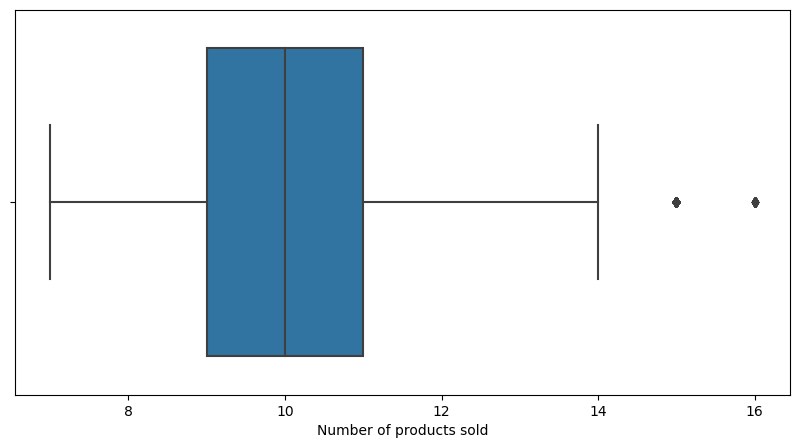

In [9]:
# boxplot
ax, fig = plt.subplots(figsize=(10, 5))
sns.boxplot(x="nb_sold", data=df)
plt.xlabel("Number of products sold")
plt.show()

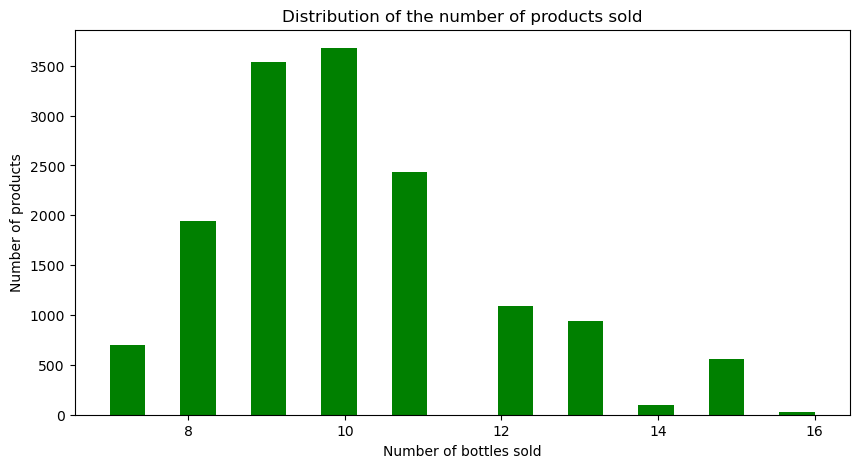

In [10]:
#historgram

ax, fig = plt.subplots(figsize=(10, 5))
plt.hist(df['nb_sold'], bins=20, color='green')
plt.title('Distribution of the number of products sold')
plt.xlabel('Number of bottles sold')
plt.ylabel('Number of products')
plt.show()

With a normal looking distribution and few outliers, no treament will be necessary.

`years_as_customer`

In [11]:
# how many customer years_as_customer > 39

df[df['years_as_customer'] > 39]

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
13741,2,email,18919515-a618-430c-9a05-2c7d8fea96af,10,97.22,63,24,california
13800,4,call,2ea97d34-571d-4e1b-95be-fea1c404649f,10,50.47,47,27,california


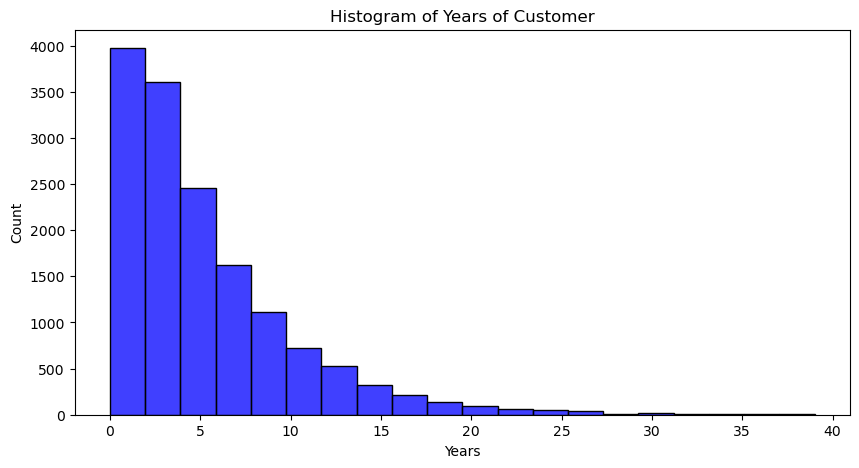

In [12]:
# histogram of years of customer where years < 40

ax, fig = plt.subplots(figsize=(10, 5))
sns.histplot(x='years_as_customer', data=df[df['years_as_customer'] < 40], bins=20, kde=False, color='blue')
plt.title('Histogram of Years of Customer')
plt.xlabel('Years')
plt.ylabel('Count')
plt.show()

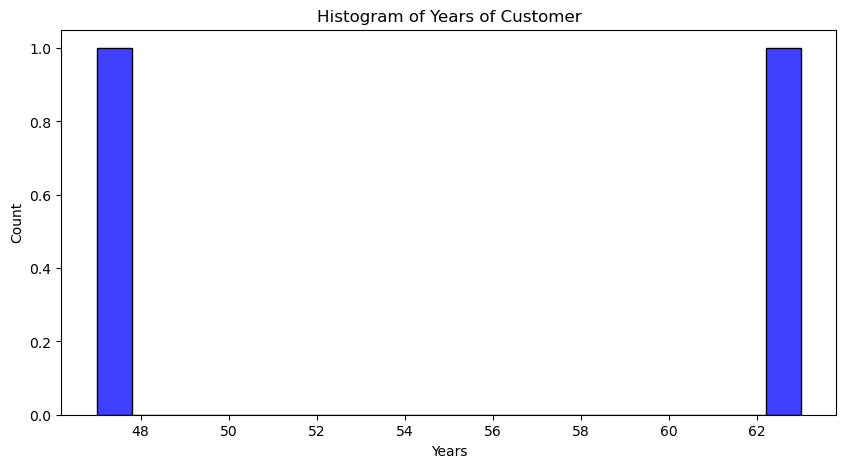

In [13]:
# histogram of years of customer where years < 40

ax, fig = plt.subplots(figsize=(10, 5))
sns.histplot(x='years_as_customer', data=df[df['years_as_customer'] > 39], bins=20, kde=False, color='blue')
plt.title('Histogram of Years of Customer')
plt.xlabel('Years')
plt.ylabel('Count')
plt.show()

With only 2 values, I will set them to the median data instead of removing or using other cleaning means.

In [14]:
df[df['years_as_customer'] > 39]['years_as_customer'] = df[df['years_as_customer'] <= 39]['years_as_customer'].median()

In [15]:
#verify that median overwote invalid values
df[df['years_as_customer'] > 39].shape[0]


2

`nb_site_visits` boxplot and histogram

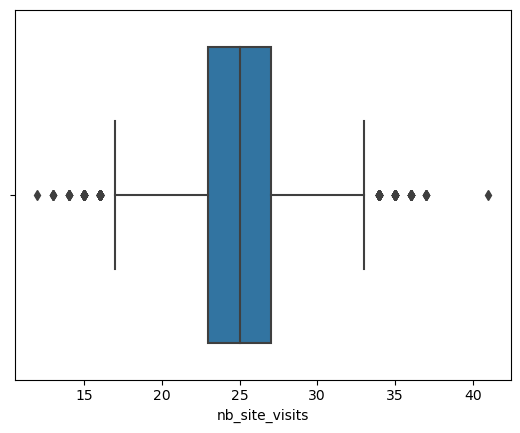

In [16]:
sns.boxplot(x="nb_site_visits", data=df, orient="v")
plt.show()

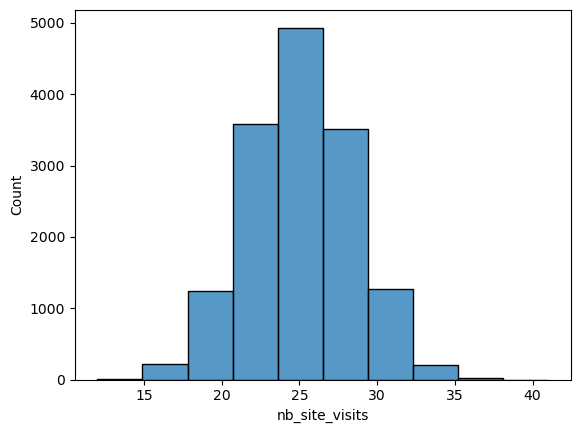

In [17]:
sns.histplot(x='nb_site_visits', data=df, bins=10)
plt.show()

`state` value counts to ensure standardization of names

In [18]:
df.state.unique()

array(['arizona', 'kansas', 'wisconsin', 'indiana', 'illinois',
       'mississippi', 'georgia', 'oklahoma', 'massachusetts', 'missouri',
       'texas', 'new york', 'maryland', 'california', 'tennessee',
       'pennsylvania', 'north dakota', 'florida', 'michigan',
       'north carolina', 'hawaii', 'colorado', 'louisiana', 'virginia',
       'new mexico', 'arkansas', 'alaska', 'oregon', 'new hampshire',
       'ohio', 'new jersey', 'connecticut', 'iowa', 'montana',
       'washington', 'kentucky', 'alabama', 'nebraska', 'south carolina',
       'minnesota', 'south dakota', 'delaware', 'maine', 'utah',
       'west virginia', 'vermont', 'rhode island', 'nevada', 'idaho',
       'wyoming'], dtype=object)

In [19]:
for col in df.columns:
    if df[col].dtype == 'object':
        #convert to category
        df[col] = df[col].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   week               15000 non-null  int64   
 1   sales_method       15000 non-null  category
 2   customer_id        15000 non-null  category
 3   nb_sold            15000 non-null  int64   
 4   revenue            13926 non-null  float64 
 5   years_as_customer  15000 non-null  int64   
 6   nb_site_visits     15000 non-null  int64   
 7   state              15000 non-null  category
dtypes: category(3), float64(1), int64(4)
memory usage: 1.3 MB


#### KNN imputation for missing values in `revenue` column

First data will need to be encoded to be able to use KNN imputation. This is done by using the pandas get_dummies function.

Then the KNN imputation is done using the fancyimpute package.

In [20]:
# copy dataframe with the customer_id column

df_encoded = df.copy(deep=True)
df_encoded.drop(columns=['customer_id'], inplace=True)

#get dummies
df_encoded = pd.get_dummies(df_encoded, drop_first=True)

df_encoded.head()

,week,nb_sold,revenue,years_as_customer,nb_site_visits,sales_method_call,sales_method_email,state_alaska,state_arizona,state_arkansas,state_california,state_colorado,state_connecticut,state_delaware,state_florida,state_georgia,state_hawaii,state_idaho,state_illinois,state_indiana,state_iowa,state_kansas,state_kentucky,state_louisiana,state_maine,state_maryland,state_massachusetts,state_michigan,state_minnesota,state_mississippi,state_missouri,state_montana,state_nebraska,state_nevada,state_new hampshire,state_new jersey,state_new mexico,state_new york,state_north carolina,state_north dakota,state_ohio,state_oklahoma,state_oregon,state_pennsylvania,state_rhode island,state_south carolina,state_south dakota,state_tennessee,state_texas,state_utah,state_vermont,state_virginia,state_washington,state_west virginia,state_wisconsin,state_wyoming
0,2,10,NaN,0,24,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6,15,225.47,1,28,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5,11,52.55,6,26,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,11,NaN,3,25,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3,9,90.49,0,28,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
# scale data
Scaler = StandardScaler()
fit = Scaler.fit(df_encoded)
scaled_data = fit.transform(df_encoded)
scaled_data = pd.DataFrame(scaled_data, columns=df_encoded.columns)
scaled_data.head()



,week,nb_sold,revenue,years_as_customer,nb_site_visits,sales_method_call,sales_method_email,state_alaska,state_arizona,state_arkansas,state_california,state_colorado,state_connecticut,state_delaware,state_florida,state_georgia,state_hawaii,state_idaho,state_illinois,state_indiana,state_iowa,state_kansas,state_kentucky,state_louisiana,state_maine,state_maryland,state_massachusetts,state_michigan,state_minnesota,state_mississippi,state_missouri,state_montana,state_nebraska,state_nevada,state_new hampshire,state_new jersey,state_new mexico,state_new york,state_north carolina,state_north dakota,state_ohio,state_oklahoma,state_oregon,state_pennsylvania,state_rhode island,state_south carolina,state_south dakota,state_tennessee,state_texas,state_utah,state_vermont,state_virginia,state_washington,state_west virginia,state_wisconsin,state_wyoming
0,-0.663059,-0.046722,NaN,-0.984370,-0.283040,-0.703080,1.004544,-0.051709,6.762320,-0.094224,-0.377619,-0.124788,-0.109897,-0.047664,-0.253242,-0.183572,-0.069449,-0.064424,-0.207118,-0.155468,-0.105463,-0.097761,-0.120019,-0.124788,-0.064944,-0.13359,-0.141393,-0.185311,-0.128859,-0.096713,-0.145507,-0.054855,-0.078126,-0.082744,-0.059547,-0.172613,-0.075044,-0.262215,-0.177668,-0.044766,-0.198023,-0.115064,-0.124512,-0.20377,-0.053618,-0.123125,-0.052353,-0.15229,-0.293144,-0.091299,-0.043245,-0.15947,-0.151141,-0.075491,-0.130981,-0.046956
1,1.751869,2.712427,2.773035,-0.786145,0.859557,-0.703080,-0.995477,-0.051709,-0.147878,-0.094224,-0.377619,-0.124788,-0.109897,-0.047664,-0.253242,-0.183572,-0.069449,-0.064424,-0.207118,-0.155468,-0.105463,10.229067,-0.120019,-0.124788,-0.064944,-0.13359,-0.141393,-0.185311,-0.128859,-0.096713,-0.145507,-0.054855,-0.078126,-0.082744,-0.059547,-0.172613,-0.075044,-0.262215,-0.177668,-0.044766,-0.198023,-0.115064,-0.124512,-0.20377,-0.053618,-0.123125,-0.052353,-0.15229,-0.293144,-0.091299,-0.043245,-0.15947,-0.151141,-0.075491,-0.130981,-0.046956
2,1.148137,0.505108,-0.872481,0.204977,0.288258,1.422313,-0.995477,-0.051709,-0.147878,-0.094224,-0.377619,-0.124788,-0.109897,-0.047664,-0.253242,-0.183572,-0.069449,-0.064424,-0.207118,-0.155468,-0.105463,-0.097761,-0.120019,-0.124788,-0.064944,-0.13359,-0.141393,-0.185311,-0.128859,-0.096713,-0.145507,-0.054855,-0.078126,-0.082744,-0.059547,-0.172613,-0.075044,-0.262215,-0.177668,-0.044766,-0.198023,-0.115064,-0.124512,-0.20377,-0.053618,-0.123125,-0.052353,-0.15229,-0.293144,-0.091299,-0.043245,-0.15947,-0.151141,-0.075491,7.634693,-0.046956
3,0.544405,0.505108,NaN,-0.389696,0.002609,-0.703080,1.004544,-0.051709,-0.147878,-0.094224,-0.377619,-0.124788,-0.109897,-0.047664,-0.253242,-0.183572,-0.069449,-0.064424,-0.207118,6.432175,-0.105463,-0.097761,-0.120019,-0.124788,-0.064944,-0.13359,-0.141393,-0.185311,-0.128859,-0.096713,-0.145507,-0.054855,-0.078126,-0.082744,-0.059547,-0.172613,-0.075044,-0.262215,-0.177668,-0.044766,-0.198023,-0.115064,-0.124512,-0.20377,-0.053618,-0.123125,-0.052353,-0.15229,-0.293144,-0.091299,-0.043245,-0.15947,-0.151141,-0.075491,-0.130981,-0.046956
4,-0.059327,-0.598551,-0.072627,-0.984370,0.859557,-0.703080,1.004544,-0.051709,-0.147878,-0.094224,-0.377619,-0.124788,-0.109897,-0.047664,-0.253242,-0.183572,-0.069449,-0.064424,4.828166,-0.155468,-0.105463,-0.097761,-0.120019,-0.124788,-0.064944,-0.13359,-0.141393,-0.185311,-0.128859,-0.096713,-0.145507,-0.054855,-0.078126,-0.082744,-0.059547,-0.172613,-0.075044,-0.262215,-0.177668,-0.044766,-0.198023,-0.115064,-0.124512,-0.20377,-0.053618,-0.123125,-0.052353,-0.15229,-0.293144,-0.091299,-0.043245,-0.15947,-0.151141,-0.075491,-0.130981,-0.046956


In [22]:
# instantiate KNN
imputer = KNN()
data_knn = scaled_data.copy(deep=True)
data_knn.iloc[:, :] = imputer.fit_transform(data_knn)

Imputing row 1/15000 with 1 missing, elapsed time: 34.083
Imputing row 101/15000 with 0 missing, elapsed time: 34.084
Imputing row 201/15000 with 0 missing, elapsed time: 34.085
Imputing row 301/15000 with 0 missing, elapsed time: 34.085
Imputing row 401/15000 with 0 missing, elapsed time: 34.086
Imputing row 501/15000 with 0 missing, elapsed time: 34.086
Imputing row 601/15000 with 0 missing, elapsed time: 34.087
Imputing row 701/15000 with 0 missing, elapsed time: 34.088
Imputing row 801/15000 with 0 missing, elapsed time: 34.088
Imputing row 901/15000 with 0 missing, elapsed time: 34.088
Imputing row 1001/15000 with 0 missing, elapsed time: 34.089
Imputing row 1101/15000 with 0 missing, elapsed time: 34.089
Imputing row 1201/15000 with 0 missing, elapsed time: 34.089
Imputing row 1301/15000 with 0 missing, elapsed time: 34.090
Imputing row 1401/15000 with 0 missing, elapsed time: 34.090
Imputing row 1501/15000 with 0 missing, elapsed time: 34.090
Imputing row 1601/15000 with 0 missi

In [23]:
#verify imputation
data_knn.revenue.isnull().sum()

0

In [24]:
#unscale data

predictions = Scaler.inverse_transform(data_knn)

predictions = pd.DataFrame(predictions, columns = df_encoded.columns)

predictions.head()

,week,nb_sold,revenue,years_as_customer,nb_site_visits,sales_method_call,sales_method_email,state_alaska,state_arizona,state_arkansas,state_california,state_colorado,state_connecticut,state_delaware,state_florida,state_georgia,state_hawaii,state_idaho,state_illinois,state_indiana,state_iowa,state_kansas,state_kentucky,state_louisiana,state_maine,state_maryland,state_massachusetts,state_michigan,state_minnesota,state_mississippi,state_missouri,state_montana,state_nebraska,state_nevada,state_new hampshire,state_new jersey,state_new mexico,state_new york,state_north carolina,state_north dakota,state_ohio,state_oklahoma,state_oregon,state_pennsylvania,state_rhode island,state_south carolina,state_south dakota,state_tennessee,state_texas,state_utah,state_vermont,state_virginia,state_washington,state_west virginia,state_wisconsin,state_wyoming
0,2.0,10.0,96.87954,0.0,24.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.938894e-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,-8.673617e-19,0.0,3.469447e-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6.0,15.0,225.47000,1.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.938894e-18,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,-8.673617e-19,0.0,3.469447e-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,11.0,52.55000,6.0,26.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.938894e-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,-8.673617e-19,0.0,3.469447e-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.0,11.0,110.20985,3.0,25.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.938894e-18,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,-8.673617e-19,0.0,3.469447e-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,9.0,90.49000,0.0,28.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.938894e-18,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.469447e-18,-8.673617e-19,0.0,3.469447e-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
 df.head()

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,email,2e72d641-95ac-497b-bbf8-4861764a7097,10,NaN,0,24,arizona
1,6,both,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47,1,28,kansas
2,5,call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55,6,26,wisconsin
3,4,email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,NaN,3,25,indiana
4,3,email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49,0,28,illinois


The inverse scalingw as succesful and so was the imputation! Now we can set the revenue column in the original dataframe to be the imputed values.

In [26]:
df['revenue'] = predictions['revenue']

In [27]:
df.head()

,week,sales_method,customer_id,nb_sold,revenue,years_as_customer,nb_site_visits,state
0,2,email,2e72d641-95ac-497b-bbf8-4861764a7097,10,96.87954,0,24,arizona
1,6,both,3998a98d-70f5-44f7-942e-789bb8ad2fe7,15,225.47000,1,28,kansas
2,5,call,d1de9884-8059-4065-b10f-86eef57e4a44,11,52.55000,6,26,wisconsin
3,4,email,78aa75a4-ffeb-4817-b1d0-2f030783c5d7,11,110.20985,3,25,indiana
4,3,email,10e6d446-10a5-42e5-8210-1b5438f70922,9,90.49000,0,28,illinois


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   week               15000 non-null  int64   
 1   sales_method       15000 non-null  category
 2   customer_id        15000 non-null  category
 3   nb_sold            15000 non-null  int64   
 4   revenue            15000 non-null  float64 
 5   years_as_customer  15000 non-null  int64   
 6   nb_site_visits     15000 non-null  int64   
 7   state              15000 non-null  category
dtypes: category(3), float64(1), int64(4)
memory usage: 1.3 MB


In [29]:
# save cleaned data into a new csv file

df.to_csv('cleaned_proudct-eda.csv', index=False)